# Model 2: Random Forest

This notebook trains a Random Forest model for sentiment analysis.

In [29]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize

# Load processed data
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

## Train and Tune Model

In [30]:
# Random Forest with GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


## Evaluate Model

In [31]:
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       201
     Neutral       1.00      1.00      1.00       208
    Positive       1.00      1.00      1.00       191

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



## Confusion Matrix

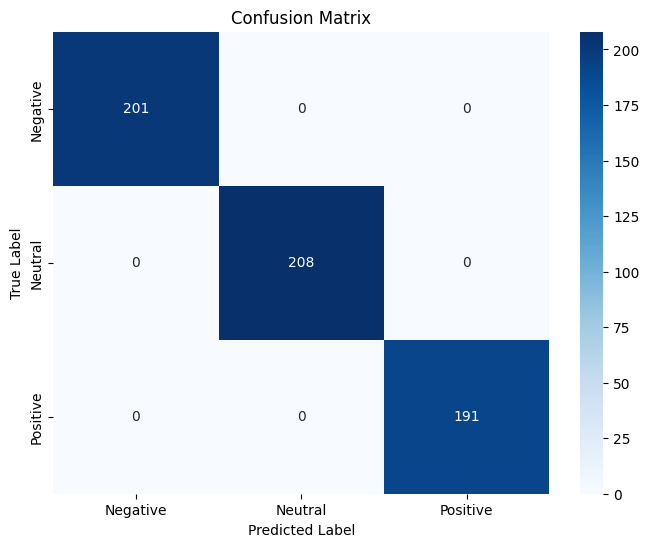

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## ROC-AUC Curve

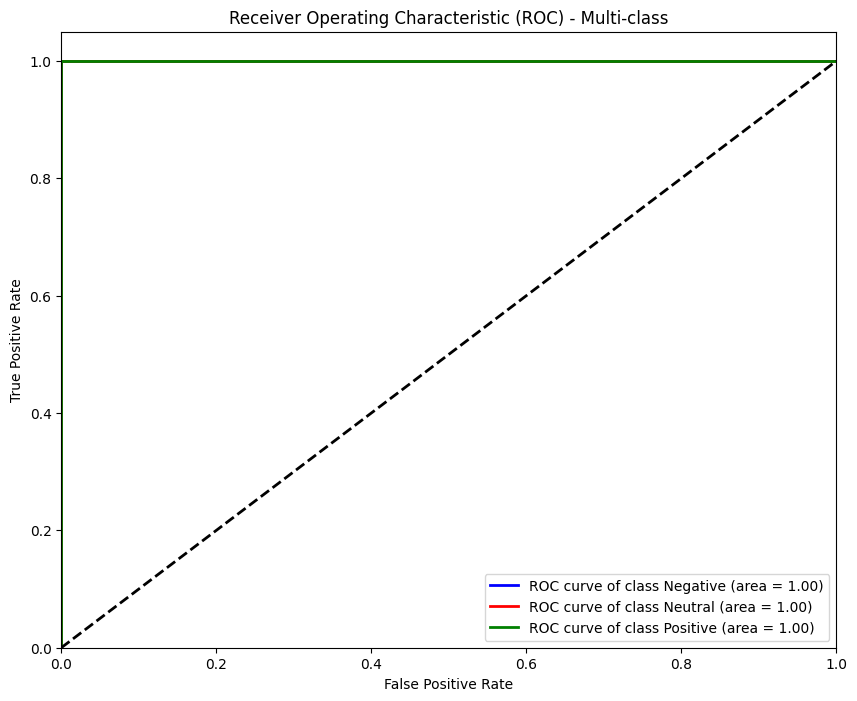

Macro-average ROC-AUC Score: 1.0000


In [33]:
# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-class')
plt.legend(loc="lower right")
plt.show()

# Calculate macro-average ROC-AUC score
roc_auc_score_macro = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
print(f"Macro-average ROC-AUC Score: {roc_auc_score_macro:.4f}")

## Save Model

In [34]:
with open('model_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
print("Model saved as model_rf.pkl")

Model saved as model_rf.pkl
